<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [2]:
!pip install --user sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
trans_df = pd.read_csv('data/wayuu/COMP.csv')
print(trans_df.shape)
print(trans_df.columns)

(81415, 2)
Index(['esp', 'wayuu'], dtype='object')


In [5]:
df_train, df_devtest = train_test_split(trans_df, test_size=2000, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=1000, random_state=42)

In [6]:
df_train.head()

,esp,wayuu
69179,daniel explica el hermano me ayudo a entender ...,mushi daniel nukaaliinjain taya chi wawalakai ...
79046,david dejo esto muy claro,tnm
65622,ayudemos a otras personas a tener una fe fuerte,wakatchinra nanoula na wayuukana
7722,"ay de ustedes, maestros de la ley y fariseos ...",jiakana karalouktamaajanakana oo'ulaka farise...
80848,loma,namuna


In [7]:
df_dev.head()

,esp,wayuu
50921,quizas haya aspectos de nuestra conducta que d...,supula nnojoliinjanain wanoujayaain ne'e nunai...
64649,el salon del reino es nuestro lugar principal ...,jamusu kojutuinjatka wamuin tu outkajawaakat
26575,suspendi las pruebas,tasha'wale'eruin tu oo'ulakawaaka
79194,vea el apendice que dice la biblia sobre el di...,ja'itaichi mojutuitpa woutiisain taya numule w...
13724,es sabado,saawanou so'uka'i


In [8]:
df_test.head()

,esp,wayuu
63300,jeronimo queria corregir malas traducciones er...,supulajatu sunoutunuin tu putchi mojukat sulat...
59930,los hermanos obedecen por un tiempo pero poco ...,nuntapa chi nashikai jashichishi ma'in namuin ...
58173,de que le sirvio a moises meditar en las prome...,kojutushaatasu numuin moises nuneekunuinjachin...
71096,obedecer los mandatos de jehova y su hijo nos ...,jikirajeena naya sunain tu taluwataapu'ukat an...
9287,he vuelto,ale'ejushi taya


# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=42)

smpl['esp_toks'] = smpl.esp.apply(tokenizer.tokenize)
smpl['wayuu_toks'] = smpl.wayuu.apply(tokenizer.tokenize)

smpl['esp_words'] = smpl.esp.apply(word_tokenize)
smpl['wayuu_words'] = smpl.wayuu.apply(word_tokenize)

In [13]:
smpl.sample(5)[['esp', 'esp_words', 'esp_toks', 'wayuu', 'wayuu_words', 'wayuu_toks']]

,esp,esp_words,esp_toks,wayuu,wayuu_words,wayuu_toks
40175,que pasos practicos pueden dar los casados par...,"[que, pasos, practicos, pueden, dar, los, casa...","[▁que, ▁pasos, ▁prac, ticos, ▁pueden, ▁dar, ▁l...",kasa naa'inrajatka na ka'wayuuseshiikana supul...,"[kasa, naa, ', inrajatka, na, ka, ', wayuusesh...","[▁kasa, ▁naa, ', in, ra, jat, ka, ▁na, ▁ka, ',..."
52502,como pueden los padres ayudar a sus hijos a te...,"[como, pueden, los, padres, ayudar, a, sus, hi...","[▁como, ▁pueden, ▁los, ▁padres, ▁ayudar, ▁a, ▁...",kasa naa'inrajatka na kachonshiikana supula al...,"[kasa, naa, ', inrajatka, na, kachonshiikana, ...","[▁kasa, ▁naa, ', in, ra, jat, ka, ▁na, ▁kach, ..."
69001,aunque el rey saul siguio desobedeciendo a jeh...,"[aunque, el, rey, saul, siguio, desobedeciendo...","[▁aunque, ▁el, ▁rey, ▁saul, ▁sigui, o, ▁des, o...",ayatushia mache'ein saul numuin je'waa alu'uin...,"[ayatushia, mache, ', ein, saul, numuin, je, '...","[▁ayat, ush, ia, ▁mache, ', ein, ▁saul, ▁n, um..."
35425,la ciencia confirma estas palabras,"[la, ciencia, confirma, estas, palabras]","[▁la, ▁ciencia, ▁confirma, ▁estas, ▁palabras]",pansaasu tia sumaa tu namakat na cientiificokana,"[pansaasu, tia, sumaa, tu, namakat, na, cienti...","[▁pan, sa, asu, ▁tia, ▁suma, a, ▁tu, ▁nam, aka..."
63760,una encuesta realizada en en estados unidos re...,"[una, encuesta, realizada, en, en, estados, un...","[▁una, ▁encu, esta, ▁realizada, ▁en, ▁en, ▁est...",so'u juyaka chaa estados unidos asakinnushii w...,"[so, ', u, juyaka, chaa, estados, unidos, asak...","[▁so, ', u, ▁ju, yaka, ▁chaa, ▁estados, ▁un, i..."


In [14]:
stats = smpl[['esp_toks', 'wayuu_toks', 'esp_words', 'wayuu_words']].applymap(len).describe()
stats

,esp_toks,wayuu_toks,esp_words,wayuu_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,18.620400,34.007100,14.584700,18.526200
std,44.910605,95.695919,33.636649,51.708451
min,1.000000,1.000000,1.000000,1.000000
25%,5.000000,9.000000,4.000000,5.000000
50%,14.000000,22.000000,11.000000,12.000000
75%,23.000000,39.000000,18.000000,21.000000
max,1671.000000,3293.000000,1266.000000,1772.000000


In [15]:
print(stats.esp_toks['mean'] / stats.esp_words['mean'])
print(stats.wayuu_toks['mean'] / stats.wayuu_words['mean'])

1.2767077828134963
1.8356219840010366


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for Wayuu? If this is too often, we need to fix it somehow</p>

In [17]:
texts_with_unk = [text for text in tqdm(trans_df.wayuu) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/81415 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1122 > 1024). Running this sequence through the model will result in indexing errors


0


<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Adding a new language tag to the tokenizer and model</h1>

In [18]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [19]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [20]:
def fix_tokenizer(tokenizer, new_lang='wayuu_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [21]:
fix_tokenizer(tokenizer)

In [22]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'wayuu_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'wayuu_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'wayuu_Cyrl', '<mask>']
[256202, 256203, 256204]


In [23]:
added_token_id = tokenizer.convert_tokens_to_ids('wayuu_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [25]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">4. Preparing the training loop</h1>

In [26]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [27]:
model.cuda();

In [28]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [39]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [40]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [41]:
LANGS = [('esp', 'spa_Latn'), ('wayuu', 'wayuu_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(item[l1])
        yy.append(item[l2])
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(["mushiijese'e muin naya ma'aka saa'in wanee trigo alu'usa'a na anoujayaashiikana nnojoliishii kasajanain numuin jesuu mal tim"], ['en cambio rechazo a todos los cristianos falsos los que estaban en la congregacion y los que se hallaban en las iglesias de la cristiandad'], 'wayuu_Cyrl', 'spa_Latn')


In [42]:
MODEL_SAVE_PATH = 'models/nllb_wayuu_COMP-v1'

<h1 id="6.-The-training-loop">5. The training loop</h1>

In [ ]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 3.949093818664551
1000 3.6492149777412415
2000 3.156293853521347
3000 2.8818012455701827
4000 2.720000967860222
5000 2.5715537875890733
6000 2.485067811727524
7000 2.401082449674606
8000 2.3431546226739886
9000 2.2660265467166902
10000 2.2012063595056532
11000 2.163306272804737
12000 2.1143499718904497
13000 2.088493980765343
14000 2.033547594547272
15000 1.9867085500359536
16000 1.9785446676015854
17000 1.9527236616015435
18000 1.920220007121563
19000 1.901045198559761
20000 1.8632270882725717
21000 1.8378291492462158
22000 1.8357450004816056
23000 1.7966260204911233
24000 1.7874556421041488
25000 1.759609328329563
26000 1.728126971900463
27000 1.7089128369688988
28000 1.7042623330950737
29000 1.7045685793161391
30000 1.656676615178585
31000 1.683177163004875
32000 1.6429022970199585
33000 1.6019238303303718
34000 1.6038463751077652
35000 1.6016481959819793
36000 1.5717758474946022
37000 1.5816773332953453
38000 1.5670506854653359
39000 1.527781506240368
40000 1.5176956335902214
410

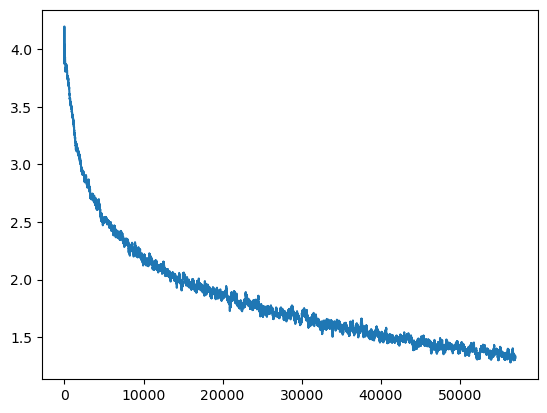

In [44]:
pd.Series(losses).ewm(100).mean().plot();

In [45]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [46]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['comienza a correr']
['puwatawaa maala']
["pu'tta sunain awatawaa"]


In [47]:
!ls -alsh $MODEL_SAVE_PATH

total 2.3G
4.0K drwxr-xr-x 2 jovyan users 4.0K Nov 25 12:00 .
4.0K drwxr-xr-x 7 jovyan users 4.0K Nov 25 12:00 ..
4.0K -rw-r--r-- 1 jovyan users  896 Nov 25 18:54 config.json
4.0K -rw-r--r-- 1 jovyan users  184 Nov 25 18:54 generation_config.json
2.3G -rw-r--r-- 1 jovyan users 2.3G Nov 25 18:54 pytorch_model.bin
4.7M -rw-r--r-- 1 jovyan users 4.7M Nov 25 18:54 sentencepiece.bpe.model
4.0K -rw-r--r-- 1 jovyan users 3.5K Nov 25 18:54 special_tokens_map.json
4.0K -rw-r--r-- 1 jovyan users  570 Nov 25 18:54 tokenizer_config.json


<h1 id="6.-Using-the-model">6. Testing the model</h1>

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [49]:
def fix_tokenizer(tokenizer, new_lang='wayuu_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [50]:
model_load_name = 'models/nllb_wayuu_COMP-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [51]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [52]:
t = "Hola como estas, ya hiciste la tarea de hoy"
print(translate(t, 'spa_Latn', 'wayuu_Cyrl'))

["anakaja muleka paa'inrule joolu'u tu a'yatawaa te'itaakat pumuin so'uka'i."]


In [53]:
translate(t, 'spa_Latn', 'wayuu_Cyrl', do_sample=True, num_beams=1, temperature=1.5)

["anataalejese paa'inruin joolu'u tu a'yatawaa anapuitpakat pia so'uka'i"]

In [54]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [55]:
esp_translated = batched_translate(df_test.esp, src_lang='spa_Latn', tgt_lang='wayuu_Cyrl')

  0%|          | 0/63 [00:00<?, ?it/s]

In [56]:
df_test['esp_translated'] = [translate(t, 'wayuu_Cyrl', 'spa_Latn')[0] for t in tqdm(df_test.wayuu)]
df_test['wayuu_translated'] = [translate(t, 'spa_Latn', 'wayuu_Cyrl')[0] for t in tqdm(df_test.esp)]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [57]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [58]:
print(bleu_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(chrf_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(bleu_calc.corpus_score(df_test['wayuu_translated'].tolist(), [df_test['wayuu'].tolist()]))
print(chrf_calc.corpus_score(df_test['wayuu_translated'].tolist(), [df_test['wayuu'].tolist()]))

BLEU = 11.56 40.4/17.7/9.8/5.7 (BP = 0.817 ratio = 0.832 hyp_len = 12041 ref_len = 14470)
chrF2++ = 30.78
BLEU = 9.35 36.6/15.2/7.5/4.0 (BP = 0.822 ratio = 0.836 hyp_len = 11197 ref_len = 13394)
chrF2++ = 35.42


In [59]:
pd.options.display.max_colwidth = 100

In [60]:
df_test.sample(10, random_state=42)[['wayuu', 'esp', 'wayuu_translated', 'esp_translated']]

,wayuu,esp,wayuu_translated,esp_translated
70906,sainkuin mmakat supushua'a eeshii ma'aka sacerdoote katoolika wainmaleepaja'a na akujuliikana pu...,y en todo el mundo hay unos sacerdotes catolicos pero hay mas de ocho millones de testigos predi...,eeshii na sacerdootekana katoolikakana sainkuin mmakat supushua'a alatushii suulia oocho miyoone...,por todo el mundo hay sacerdotes catolicos pero hay mas de millones de testigos de jehova predic...
80263,lania,amuleto,e'ipo'u,lania
3278,"je yaa saa'ujee tu juraskeetkat, eesu nayaakua wane kasa eekai katunain. wayawayatsu tu natunaka...","encima del arca estaban los querubines, representantes de la presencia gloriosa de dios, que cub...","otta musia joolu'u, nnojotsu joolu'u wekirajaain soo'omuin suchiki tu naa'inrapu'ukat chi maleiw...",y con el sello de la sangre de la victima sacrificada en el templo se guardaban los simbolos de ...
76701,eesu apunuinsu kasa mojuka aa'ujee walaulaajaale saa'u wakuwa'ipa,actuar con arrogancia es un grave error por que,jamusu mojuka ma'in wa'waataain sulu'u wakuwa'ipa,hay tres cosas malas que ocurren cuando uno tiene un control exagerado sobre si mismo
20940,akulajawaa ma'in,es muy aburrido,akulajaashaatasu naa'in,es aburrido
74021,kee'ireesu naa'in je'waa piyaawatuin saa'u tu sumakat tu wiwuliakat jee piyaawatuin saa'u suka p...,quiere que uses tu capacidad de pensar para que conozcas la biblia y encuentres pruebas de que e...,kee'ireesu naa'in pi'raajuin tu wiwuliakat sumaa putujaain saa'u shiimain nunuikin shia,jehova quiere que entiendas lo que dice la biblia y que lo entiendas personalmente
29429,tayoutajuin taa inruin,rehuso hacerlo,nnojotsu tachekuin taa'inruin,casi lo hice
20482,kojuyaalashi taya nuulia,tengo una deuda con el,kojuyaalashi taya nuulia,le debo algo
5449,"je mapa ja'yuumuin, o'unushi jesus sulu'ujee tu pueulokat chaa eere yuutuulin. otta tu wayuukolu...","al hacerse de dia, jesus salio de la ciudad y se retiro a un lugar solitario. la gente estaba bu...","shiasa motsapa ka'ikat, o'unushi jesus anooipa'amuin supula o'unaa eemuin wane anooipa'amuin eer...","al amanecer el dia, jesus salio y se quedo en el desierto. los judios lo buscaban y lo empenaron..."
70951,eeshii na kamalainkana amuin tu sumakat alateetkat mapeena suka saashajaain suchiki tu alateetka...,a otros les gustan libros como el de revelacion que tiene profecias que hablan de las cosas que ...,kamalainsu ma'in numuin wanee wayuu tu putchi sulu'ukat alateetkat mapeena,a algunos les encanta la profecia porque dice lo que pasara en el futuro
